In [21]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import iris

In [22]:
fdir='/badc/srip/data/zonal/common_grid/era_interim/'
fpath='TEM_monthly_2000_01.nc'

ds = xr.open_mfdataset(fdir+fpath)

ds

<xarray.Dataset>
Dimensions:         (time: 1, pressure: 22, latitude: 73)
Coordinates:
  * time            (time) datetime64[ns] 2000-01-14T09:00:00
  * pressure        (pressure) float32 1e+03 925.0 850.0 700.0 ... 3.0 2.0 1.0
  * latitude        (latitude) float32 -90.0 -87.5 -85.0 ... 85.0 87.5 90.0
Data variables: (12/37)
    EPF_p_qg        (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPF_phi_qg      (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPFD_p_qg       (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPFD_phi_qg     (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPF_p_pr        (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPF_phi_pr      (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    ...              ...
    EPFD_p_qg_k3    (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPFD_phi_qg_k3  (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPF_p_pr_k3     (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPF_phi_pr_k3   (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPFD_p_pr_k3    (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
    EPFD_phi_pr_k3  (time, pressure, latitude) float32 dask.array<chunksize=(1, 22, 73), meta=np.ndarray>
Attributes:
    Title:                     Transformed Eulerian Mean (TEM) diagnostics / ...
    Description:               EP flux and other terms from the TEM equations...
    Reanalysis:                era_interim
    Project_Homepage:          http://s-rip.ees.hokudai.ac.jp/
    SPARC_Homepage:            http://www.sparc-climate.org/
    Author:                    Patrick Martineau
    Report_issues_with_data:   patrick.martineau2@mail.mcgill.ca
    Creation_Date:             25-Oct-2017 08:49:08
    history:                   Wed Oct 25 08:49:08 2017: ncra /data/A/SRIP_da...
    nco_openmp_thread_number:  1

# Rosie's code

## Import data

In [23]:
# set constants
Hscale=7000 # m
P_surf=1000 # hPa
earth_radius=6371.e3 # m

# Fy: Want description primitive eqn: wavenumber "" (EPF_phi_pr)
standard_name='northward_eliassen_palm_flux_in_air'
con=iris.Constraint(standard_name)        
fy_fields=iris.load(fdir+fpath,con)
fy_fields=fy_fields.extract(iris.AttributeConstraint(wavenumber=""))
fy_fields=fy_fields.extract(iris.AttributeConstraint(description="Uses primitive equation"))
fy_fields=fy_fields[0]
if fy_fields.coords('air_pressure'): fy_fields.coord('air_pressure').rename('pressure') 
# fy_fields

### Checkpoint

In [24]:
np.testing.assert_allclose(ds.EPF_phi_pr[0].values, fy_fields[0].data, rtol=1e-7)
# np.testing.assert_allclose(ds.EPF_p_pr[0].values, fz_fields[0].data, rtol=1e-7)

## Scale pressure coordinates

In [25]:
# define dimensions
plevs_vec = fy_fields.coord('pressure').points
lats = fy_fields.coord('latitude').points

# Convert from log pressure to pressure coordinates
p_ratio = np.repeat(plevs_vec/P_surf, lats.size).reshape((plevs_vec.size,lats.size))
fy_fields = iris.analysis.maths.multiply(fy_fields,p_ratio)

## Differentiate

In [26]:
# Differentiate wrt φ
fy_fields=fy_fields[0] # take the time index 'out' 
deriv1=fy_fields.copy()

latsR = np.deg2rad(lats)
# latsR= fy_fields.coord('latitude').points*2*np.pi/360	# in radians

cos_lats=np.cos(latsR)
Fcoslat=iris.analysis.maths.multiply(fy_fields,cos_lats)
deriv1.data=np.gradient(Fcoslat.data,latsR,axis=1) # central difference except end points where forwards/backwards difference

# Divide by a cos(φ)
deriv1=iris.analysis.maths.divide(deriv1,cos_lats)
deriv1=iris.analysis.maths.divide(deriv1,(earth_radius))

# Plot 'em

In [27]:
demon = (cos_lats * earth_radius)

deriv1 = deriv1 / demon

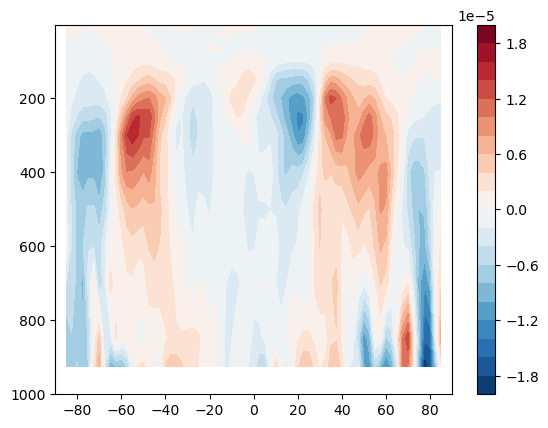

In [28]:
plt.figure()
plt.contourf(lats, plevs_vec, deriv1.data, cmap='RdBu_r',
             levels=np.linspace(-2e-5, 2e-5, 21) )
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

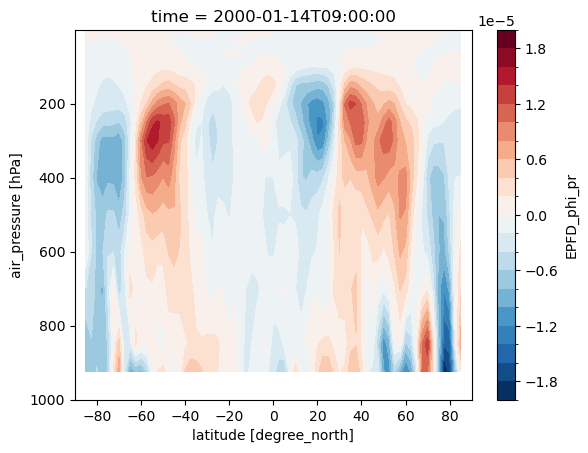

In [29]:
divFy = ds['EPFD_phi_pr'][0] * p_ratio
# divFy = divFy.sel( pressure=slice(1000, 20) )
divFy.plot.contourf(levels=np.linspace(-2e-5, 2e-5, 21), yincrease=False)

In [30]:
# passes assertion at rtol=1e-3
np.testing.assert_allclose(deriv1.data, divFy.values, rtol=1e-3)

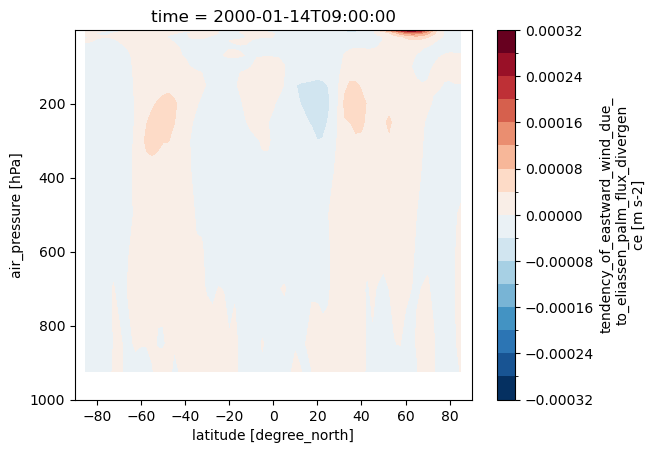

In [31]:
# ds = ds.where( ds.pressure > 20., drop=True)
ds['EPFD_phi_pr'].isel(time=0).plot.contourf(levels=20, yincrease=False)